In [2]:
import wandb
import os
import re

import numpy as np
import cupy as cp

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(style='darkgrid')
%matplotlib inline


def calc_c95(table, value, group_name='name'):

    print(value)
    stats = table.groupby([group_name])[value].agg(['mean', 'count', 'std'])

    ci95_hi = []
    ci95_lo = []

    for i in stats.index:
        m, c, s = stats.loc[i]
        ci95_hi.append(+ 1.96*s/np.sqrt(c))
        ci95_lo.append(- 1.96*s/np.sqrt(c))

    stats['ci95_hi'] = ci95_hi
    stats['ci95_lo'] = ci95_lo

    print(stats)
    print('\n')

# Width

In [8]:
name = 'fgsm-mnist_fc_none_5000_0'

# check id
api = wandb.Api()
runs = api.runs("liuyuezhang/cerebellum")
for run in runs:
    if run.name == name:
        run_id = run.id
        print(run.name, run.id)

fgsm-mnist_fc_none_5000_0 3girifyj


In [3]:
ENV = 'mnist'

run_dict = {}

api = wandb.Api()
runs = api.runs("liuyuezhang/cerebellum")
for run in runs:
    if run.name.startswith(ENV + '_plain_none'):
        run_dict[ENV] = run
        print(run.name, run.id)
    elif run.name.startswith('fgsm-'+ ENV + '_plain_none'):
        run_dict['fgsm-' + ENV] = run
        print(run.name, run.id)
    elif run.name.startswith('pgd-' + ENV + '_plain_none'):
        run_dict['pgd-' + ENV] = run
        print(run.name, run.id)
        
baseline_dict = {}

for env, run in run_dict.items():
    # train
    if env == ENV:
        baseline = pd.DataFrame()
        history = run.history(samples=1000)
        baseline['train_acc'] = history['train_acc'].dropna()
        baseline['epoch'] = history['epoch'].dropna()
    # attack
    else:
        baseline = pd.DataFrame()
        history = run.history(samples=1000)
        baseline['attack_acc'] = history['attack_acc'].dropna()
        baseline['eps'] = history['eps'].dropna()
    baseline_dict[env] = baseline
    print(baseline)

pgd-mnist_plain_none_50_0 1c2u2ibz
fgsm-mnist_plain_none_50_0 1rfeboyz
mnist_plain_none_50_0 11ndw16g
   attack_acc   eps
0      0.9925  0.00
1      0.9107  0.05
2      0.4734  0.10
3      0.0716  0.15
4      0.0028  0.20
5      0.0001  0.25
6      0.0000  0.30
   attack_acc   eps
0      0.9925  0.00
1      0.9442  0.05
2      0.7722  0.10
3      0.5062  0.15
4      0.2953  0.20
5      0.1552  0.25
6      0.0795  0.30
     train_acc  epoch
59    0.956450    1.0
120   0.984367    2.0
181   0.989433    3.0
242   0.992283    4.0
303   0.993967    5.0
364   0.995167    6.0
425   0.996450    7.0
486   0.997067    8.0
547   0.997850    9.0
608   0.998200   10.0


In [4]:
# find runs
api = wandb.Api()
runs = api.runs("liuyuezhang/cerebellum")
print(len(runs))

255


In [3]:
ENV = 'mnist'
METHOD = 'fc'
LTD = ['none']
N = [1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000]

df = pd.DataFrame()
table = pd.DataFrame()
for run in runs:    
    m = re.match('(.*)_(.*)_(.*)_(.*)_(.*)', run.name)
    env = m.group(1)
    method = m.group(2)
    ltd = m.group(3)
    n = int(m.group(4))
    seed = int(m.group(5))
    
    if env == ENV and method == METHOD and ltd in LTD and n in N:
        temp = pd.DataFrame()
        history = run.history(samples=1000)
        temp['train_acc'] = history['train_acc'].dropna()
        temp['epoch'] = history['epoch'].dropna()
        temp[''] = '${}$'.format(n)
        temp['seed'] = seed
        df = df.append(temp)
        
        best_train_acc = history['best_train_acc'].dropna().item() * 100
        best_test_acc = history['best_test_acc'].dropna().item() * 100
        name = env + '_' + method + '_' + ltd + '_' + str(n)
        table = table.append(pd.DataFrame(
            {'best_train_acc': best_train_acc, 'best_test_acc': best_test_acc, 'name': name}, index=[run.name]))
    
calc_c95(table, 'best_train_acc')
calc_c95(table, 'best_test_acc')

best_train_acc
                           mean  count       std   ci95_hi   ci95_lo
name                                                                
mnist_fc_none_1000    92.155001      2  0.082494  0.114331 -0.114331
mnist_fc_none_10000   98.057500      2  0.045961  0.063699 -0.063699
mnist_fc_none_100000  99.244168      2  0.034177  0.047367 -0.047367
mnist_fc_none_2000    94.666666      2  0.061282  0.084932 -0.084932
mnist_fc_none_20000   98.665833      2  0.024749  0.034300 -0.034300
mnist_fc_none_200000  99.309167      2  0.027105  0.037565 -0.037565
mnist_fc_none_5000    96.940833      2  0.055389  0.076766 -0.076766
mnist_fc_none_50000   99.120000      2  0.011788  0.016338 -0.016338


best_test_acc
                           mean  count       std   ci95_hi   ci95_lo
name                                                                
mnist_fc_none_1000    93.140000      2  0.212134  0.294002 -0.294002
mnist_fc_none_10000   97.239998      2  0.183849  0.254801 -0.254801
mni

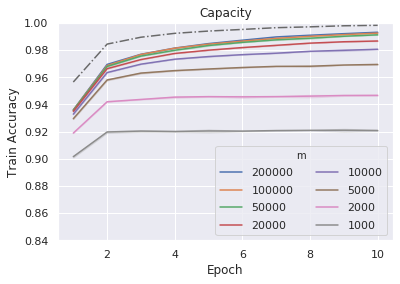

In [7]:
plt.plot(baseline_dict[ENV]['epoch'], baseline_dict[ENV]['train_acc'], '-.', color='dimgrey')
ax = sns.lineplot(x='epoch', y='train_acc', hue='', ci=95, n_boot=1000,
                  hue_order=['$200000$', '$100000$', '$50000$', '$20000$', '$10000$', '$5000$', '$2000$', '$1000$'],
                  data=df)
ax.set(title='Capacity', xlabel='Epoch', ylabel='Train Accuracy')
plt.ylim(0.84, 1.0)
plt.legend(loc='lower right', ncol=2, title='m')
plt.savefig('/home/liuyuezhangadam/Desktop/cerebellum/fig/wide_'+ENV+'.png', dpi=300, bbox_inches='tight')

In [14]:
EPS=0.1
ATTACK = 'fgsm'
ENV = ATTACK + '-mnist'
METHOD = 'fc'
LTD = ['none']
N = [1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000]

df = pd.DataFrame()
table = pd.DataFrame()
for run in runs:    
    m = re.match('(.*)_(.*)_(.*)_(.*)_(.*)', run.name)
    env = m.group(1)
    method = m.group(2)
    ltd = m.group(3)
    n = int(m.group(4))
    seed = int(m.group(5))
    
    if env == ENV and method == METHOD and ltd in LTD and n in N:
        temp = pd.DataFrame()
        history = run.history(samples=1000)
        temp['attack_acc'] = history['attack_acc'].dropna()
        temp['eps'] = history['eps'].dropna()
        temp[''] = "${}$".format(n)
        temp['seed'] = seed
        df = df.append(temp)
        
        max_attack_acc = temp[temp['eps'] == EPS]['attack_acc'].item() * 100
        name = env + '_' + method + '_' + ltd + '_' + str(n)
        table = table.append(pd.DataFrame(
            {'max_attack_acc': max_attack_acc, 'name': name}, index=[run.name]))
    
calc_c95(table, 'max_attack_acc')

max_attack_acc
                             mean  count       std  ci95_hi  ci95_lo
name                                                                
fgsm-mnist_fc_none_1000    20.305      2  0.091924   0.1274  -0.1274
fgsm-mnist_fc_none_10000   34.400      2  5.345727   7.4088  -7.4088
fgsm-mnist_fc_none_100000  46.340      2  6.392245   8.8592  -8.8592
fgsm-mnist_fc_none_2000    26.970      2  0.367696   0.5096  -0.5096
fgsm-mnist_fc_none_20000   41.080      2  4.426488   6.1348  -6.1348
fgsm-mnist_fc_none_200000  48.795      2  3.655742   5.0666  -5.0666
fgsm-mnist_fc_none_5000    33.645      2  0.728320   1.0094  -1.0094
fgsm-mnist_fc_none_50000   37.570      2  6.349819   8.8004  -8.8004




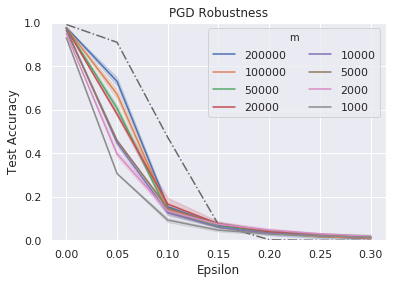

In [13]:
plt.plot(baseline_dict[ENV]['eps'], baseline_dict[ENV]['attack_acc'], '-.', color='dimgray')
ax = sns.lineplot(x='eps', y='attack_acc', hue='', ci=95, n_boot=1000,
                  hue_order=['$200000$', '$100000$', '$50000$', '$20000$', '$10000$', '$5000$', '$2000$', '$1000$'],
                  data=df)
ax.set(title=ATTACK.upper() + ' Robustness', xlabel='Epsilon', ylabel='Test Accuracy')
plt.ylim(0, 1)
plt.legend(loc='upper right', ncol=2, title='m')
plt.savefig('/home/liuyuezhangadam/Desktop/cerebellum/fig/wide_'+ENV+'.png', dpi=300, bbox_inches='tight')

# LTD

In [5]:
ENV = 'mnist'
METHOD = 'fc'
LTD = ['none', 'ma']
N = [1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000]

df = pd.DataFrame()
table = pd.DataFrame()
for run in runs:    
    m = re.match('(.*)_(.*)_(.*)_(.*)_(.*)', run.name)
    env = m.group(1)
    method = m.group(2)
    ltd = m.group(3)
    n = int(m.group(4))
    seed = int(m.group(5))

    if env == ENV and method == METHOD and ltd in LTD and n in N:
        temp = pd.DataFrame()
        history = run.history(samples=1000)
        temp['train_acc'] = history['train_acc'].dropna()
        temp['epoch'] = history['epoch'].dropna()
        temp['m'] = '${}$'.format(n)
        temp['LTD'] = ltd
        temp['seed'] = seed
        df = df.append(temp)
        name = env + '_' + method + '_' + ltd + '_' + str(n)
        best_train_acc = history['best_train_acc'].dropna().item() * 100
        best_test_acc = history['best_test_acc'].dropna().item() * 100
        
        table = table.append(pd.DataFrame(
            {'best_train_acc': best_train_acc, 'best_test_acc': best_test_acc, 'name': name}, index=[run.name]))
    
calc_c95(table, 'best_train_acc')
calc_c95(table, 'best_test_acc')

best_train_acc
                           mean  count       std   ci95_hi   ci95_lo
name                                                                
mnist_fc_ma_1000      93.185833      2  0.020032  0.027763 -0.027763
mnist_fc_ma_10000     98.406667      2  0.035353  0.048996 -0.048996
mnist_fc_ma_100000    99.216667      2  0.002356  0.003265 -0.003265
mnist_fc_ma_2000      95.495835      2  0.041249  0.057168 -0.057168
mnist_fc_ma_20000     98.863333      2  0.018857  0.026134 -0.026134
mnist_fc_ma_200000    99.263334      2  0.014144  0.019603 -0.019603
mnist_fc_ma_5000      97.526667      2  0.002356  0.003265 -0.003265
mnist_fc_ma_50000     99.145001      2  0.004712  0.006531 -0.006531
mnist_fc_none_1000    92.155001      2  0.082494  0.114331 -0.114331
mnist_fc_none_10000   98.057500      2  0.045961  0.063699 -0.063699
mnist_fc_none_100000  99.244168      2  0.034177  0.047367 -0.047367
mnist_fc_none_2000    94.666666      2  0.061282  0.084932 -0.084932
mnist_fc_none_20000

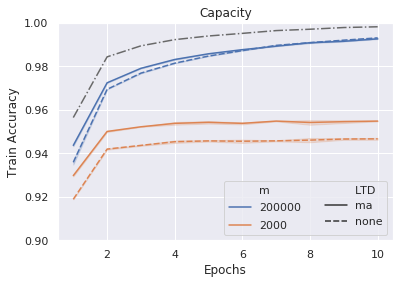

In [11]:
plt.plot(baseline_dict[ENV]['epoch'], baseline_dict[ENV]['train_acc'], '-.', color='dimgrey')
ax = sns.lineplot(x='epoch', y='train_acc', hue='m', style='LTD', ci=95, n_boot=1000,
                  hue_order=['$200000$', '$2000$'],
                  style_order=['ma', 'none'],
                  data=df)
ax.set(title='Capacity', xlabel='Epochs', ylabel='Train Accuracy')
plt.ylim(0.9, 1.0)
plt.legend(loc='lower right', ncol=2)
plt.savefig('/home/liuyuezhangadam/Desktop/cerebellum/fig/ltd_'+ENV+'.png', dpi=300, bbox_inches='tight')

In [9]:
EPS = 0.1
ATTACK = 'pgd'
ENV = ATTACK + '-mnist'
METHOD = 'fc'
LTD = ['none', 'ma']
N = [1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000]

df = pd.DataFrame()
table = pd.DataFrame()
for run in runs:    
    m = re.match('(.*)_(.*)_(.*)_(.*)_(.*)', run.name)
    env = m.group(1)
    method = m.group(2)
    ltd = m.group(3)
    n = int(m.group(4))
    seed = int(m.group(5))
    
    if env == ENV and method == METHOD and ltd in LTD and n in N:
        temp = pd.DataFrame()
        history = run.history(samples=1000)
        temp['attack_acc'] = history['attack_acc'].dropna()
        temp['eps'] = history['eps'].dropna()
        temp['m'] = '${}$'.format(n)
        temp['LTD'] = ltd
        temp['seed'] = seed
        df = df.append(temp)
        
        max_attack_acc = temp[temp['eps'] == EPS]['attack_acc'].item() * 100
        name = env + '_' + method + '_' + ltd + '_' + str(n)
        table = table.append(pd.DataFrame(
            {'max_attack_acc': max_attack_acc, 'name': name}, index=[run.name]))
    
calc_c95(table, 'max_attack_acc')

max_attack_acc
                            mean  count       std  ci95_hi  ci95_lo
name                                                               
pgd-mnist_fc_ma_1000      70.015      2  0.289914   0.4018  -0.4018
pgd-mnist_fc_ma_10000     83.735      2  2.524371   3.4986  -3.4986
pgd-mnist_fc_ma_100000    69.950      2  0.169706   0.2352  -0.2352
pgd-mnist_fc_ma_2000      81.040      2  4.002224   5.5468  -5.5468
pgd-mnist_fc_ma_20000     70.305      2  7.459977  10.3390 -10.3390
pgd-mnist_fc_ma_200000    65.970      2  2.899138   4.0180  -4.0180
pgd-mnist_fc_ma_5000      86.360      2  0.438406   0.6076  -0.6076
pgd-mnist_fc_ma_50000     76.980      2  8.951972  12.4068 -12.4068
pgd-mnist_fc_none_1000     9.285      2  1.336432   1.8522  -1.8522
pgd-mnist_fc_none_10000   12.740      2  1.880904   2.6068  -2.6068
pgd-mnist_fc_none_100000  14.375      2  2.778930   3.8514  -3.8514
pgd-mnist_fc_none_2000    13.440      2  1.979899   2.7440  -2.7440
pgd-mnist_fc_none_20000   16.700 

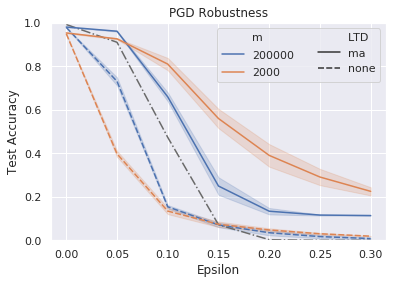

In [19]:
plt.plot(baseline_dict[ENV]['eps'], baseline_dict[ENV]['attack_acc'], '-.', color='dimgrey')
ax = sns.lineplot(x='eps', y='attack_acc', hue='m', style='LTD', ci=95, n_boot=1000,
                  hue_order=['$200000$', '$2000$'],
                  style_order=['ma', 'none'],
                  data=df)
ax.set(title=ATTACK.upper() + ' Robustness', xlabel='Epsilon', ylabel='Test Accuracy')
plt.ylim(0, 1.0)
plt.legend(loc='upper right', ncol=2)
plt.savefig('/home/liuyuezhangadam/Desktop/cerebellum/fig/ltd_'+ENV+'.png', dpi=300, bbox_inches='tight')

# Sparseness

In [11]:
ENV = 'mnist'
K = [1, 2, 4, 10, 20, 50, 100, 200, 400, 784]
METHOD = ['rc']
LTD = ['ma']

df = pd.DataFrame()
table = pd.DataFrame()
for run in runs:    
    m = re.match('(.*)_(.*)-(.*)_(.*)_(.*)_(.*)', run.name)
    if m is not None:
        env = m.group(1)
        method = m.group(2)
        k = int(m.group(3))
        ltd = m.group(4)
        n = int(m.group(5))
        seed = int(m.group(6))

        if env == ENV and method in METHOD and k in K and ltd in LTD:
            temp = pd.DataFrame()
            history = run.history(samples=1000)

            temp['best_train_acc'] = history['best_train_acc'].dropna()
            temp['best_test_acc'] = history['best_test_acc'].dropna()
            temp['Granule'] = method
            temp['k'] = k
            temp['seed'] = seed
            df = df.append(temp)

            best_train_acc = history['best_train_acc'].dropna().item() * 100
            best_test_acc = history['best_test_acc'].dropna().item() * 100
            name = env + '_' + method + '-' + str(k) + '_' + ltd + '_' + str(n)
            table = table.append(pd.DataFrame(
                {'best_train_acc': best_train_acc, 'best_test_acc': best_test_acc, 'name': name}, index=[run.name]))
    
calc_c95(table, 'best_train_acc')
calc_c95(table, 'best_test_acc')

best_train_acc
                            mean  count       std   ci95_hi   ci95_lo
name                                                                 
mnist_rc-100_ma_40000  99.071667      2  0.007068  0.009796 -0.009796
mnist_rc-10_ma_160000  98.654166      2  0.020032  0.027763 -0.027763
mnist_rc-1_ma_228571   83.515832      2  0.015320  0.021233 -0.021233
mnist_rc-200_ma_21818  98.879999      2  0.004712  0.006531 -0.006531
mnist_rc-20_ma_120000  98.995000      2  0.002360  0.003271 -0.003271
mnist_rc-2_ma_218182   96.285000      2  0.058926  0.081667 -0.081667
mnist_rc-400_ma_11429  98.478332      2  0.004716  0.006536 -0.006536
mnist_rc-4_ma_200000   97.664168      2  0.008248  0.011431 -0.011431
mnist_rc-50_ma_68571   99.114165      2  0.045961  0.063699 -0.063699
mnist_rc-784_ma_5970   97.826666      2  0.042425  0.058798 -0.058798


best_test_acc
                            mean  count       std   ci95_hi   ci95_lo
name                                                       

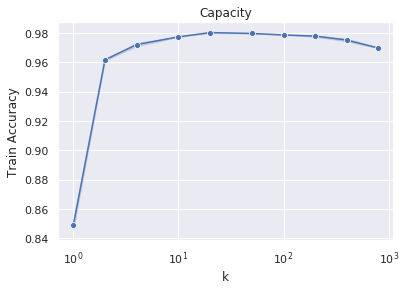

In [21]:
ax = sns.lineplot(x='k', y='best_test_acc', ci=95, n_boot=1000, marker='o',
                  data=df)
ax.set(title='Capacity', xlabel='k', xscale='log', ylabel='Train Accuracy')
# plt.ylim(0.3, 0.6)
# plt.legend(loc='lower right')
plt.savefig('/home/liuyuezhangadam/Desktop/cerebellum/fig/sparse_'+ENV+'.png', dpi=300, bbox_inches='tight')

In [28]:
EPS = 0.1
ATTACK = 'pgd'
ENV = ATTACK + '-mnist'
K = [1, 2, 4, 10, 20, 50, 100, 200, 400, 784]

METHOD = ['rc']
LTD = ['ma']

df = pd.DataFrame()
table = pd.DataFrame()
for run in runs:    
    m = re.match('(.*)_(.*)-(.*)_(.*)_(.*)_(.*)', run.name)
    if m is not None:
        env = m.group(1)
        method = m.group(2)
        k = int(m.group(3))
        ltd = m.group(4)
        n = int(m.group(5))
        seed = int(m.group(6))

        if env == ENV and method in METHOD and k in K and ltd in LTD:
            temp = pd.DataFrame()
            history = run.history(samples=1000)

            temp['attack_acc'] = history['attack_acc'].dropna()
#             temp[''] = history['eps'].dropna().apply(
#                 lambda x: '${}$'.format(int(x * 255)))
            temp[''] = history['eps'].dropna().apply(
                lambda x: '${}$'.format(x))
            temp['eps'] = history['eps']
            temp['k'] = k
            temp['Granule'] = method
            temp['seed'] = seed
            df = df.append(temp)

            max_attack_acc = temp[temp['eps'] == EPS]['attack_acc'].item() * 100
            name = env + '_' + method + '-' + str(k) + '_' + ltd + '_' + str(n)
            table = table.append(pd.DataFrame(
                {'max_attack_acc': max_attack_acc, 'name': name}, index=[run.name]))
    
calc_c95(table, 'max_attack_acc')

max_attack_acc
                             mean  count       std  ci95_hi  ci95_lo
name                                                                
pgd-mnist_rc-100_ma_40000  73.585      2  0.289914   0.4018  -0.4018
pgd-mnist_rc-10_ma_160000  88.310      2  9.560084  13.2496 -13.2496
pgd-mnist_rc-1_ma_228571   55.620      2  0.480833   0.6664  -0.6664
pgd-mnist_rc-200_ma_21818  72.055      2  4.475986   6.2034  -6.2034
pgd-mnist_rc-20_ma_120000  83.885      2  3.995153   5.5370  -5.5370
pgd-mnist_rc-2_ma_218182   94.115      2  0.954594   1.3230  -1.3230
pgd-mnist_rc-400_ma_11429  85.130      2  1.371787   1.9012  -1.9012
pgd-mnist_rc-4_ma_200000   95.235      2  0.982878   1.3622  -1.3622
pgd-mnist_rc-50_ma_68571   75.755      2  2.397092   3.3222  -3.3222
pgd-mnist_rc-784_ma_5970   83.650      2  2.333452   3.2340  -3.2340




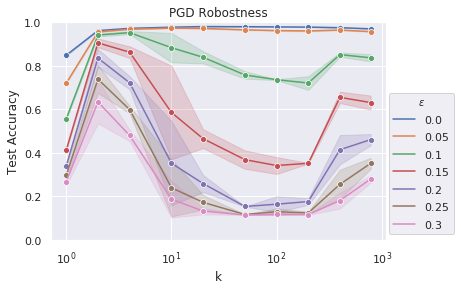

In [29]:
ax = sns.lineplot(x='k', y='attack_acc', hue='', ci=95, n_boot=1000, marker='o',
                  data=df)
ax.set(title=ATTACK.upper() + ' Robostness', xlabel='k', xscale='log', ylabel='Test Accuracy')
plt.ylim(0, 1.0)
lgd = plt.legend(loc='lower right', title='$\epsilon$', bbox_to_anchor=(1.22, 0))
# plt.ylim(0.0, 0.6)
# lgd = plt.legend(loc='lower right', title='$\epsilon\,(1/255)$', bbox_to_anchor=(1.22, 0))
# plt.savefig('/home/liuyuezhangadam/Desktop/cerebellum/fig/ltd+sparse_'+ENV+'.png', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')

# Cerebellum

In [27]:
ENV = 'mnist'
MODEL = {'plain_none_50': 'CNN', 
         'rc-4_ma_200000': 'Cerebellum',
         'rc-4_none_200000': 'Base + RC',
         'fc_ma_5970': 'Base + LTD',
         'fc_none_5970': 'Base'}

# ENV = 'cifar10'
# MODEL = {'rc-4_ma_200000': 'Cerebellum',
#          'rc-4_none_200000': 'Base + RC',
#          'fc_ma_1166': 'Base + LTD',
#          'fc_none_1166': 'Base'}


df = pd.DataFrame()
table = pd.DataFrame()
for run in runs:    
    m = re.match('(.*)_(.*_.*_.*)_(.*)', run.name)
    env = m.group(1)
    model = m.group(2)
    seed = int(m.group(3))
    
    if env == ENV and model in MODEL.keys():
        temp = pd.DataFrame()
        history = run.history(samples=1000)
        temp['train_acc'] = history['train_acc'].dropna()
        temp['epoch'] = history['epoch'].dropna()
        temp[''] = MODEL[model]
        temp['seed'] = seed
        df = df.append(temp)
        
        best_train_acc = history['best_train_acc'].dropna().item() * 100
        best_test_acc = history['best_test_acc'].dropna().item() * 100
        name = env + '_' + model
        table = table.append(pd.DataFrame(
            {'best_train_acc': best_train_acc, 'best_test_acc': best_test_acc, 'name': name}, index=[run.name]))
    
calc_c95(table, 'best_train_acc')
calc_c95(table, 'best_test_acc')

best_train_acc
                             mean  count       std   ci95_hi   ci95_lo
name                                                                  
mnist_fc_ma_5970        97.823334      2  0.014144  0.019603 -0.019603
mnist_fc_none_5970      97.281668      2  0.047141  0.065334 -0.065334
mnist_plain_none_50     99.820000      1       NaN       NaN       NaN
mnist_rc-4_ma_200000    97.664168      2  0.008248  0.011431 -0.011431
mnist_rc-4_none_200000  97.509167      2  0.008248  0.011431 -0.011431


best_test_acc
                             mean  count       std   ci95_hi   ci95_lo
name                                                                  
mnist_fc_ma_5970        96.930000      2  0.155560  0.215595 -0.215595
mnist_fc_none_5970      96.599999      2  0.070710  0.097999 -0.097999
mnist_plain_none_50     99.250001      1       NaN       NaN       NaN
mnist_rc-4_ma_200000    97.200000      2  0.155564  0.215601 -0.215601
mnist_rc-4_none_200000  96.950001      2  0.05

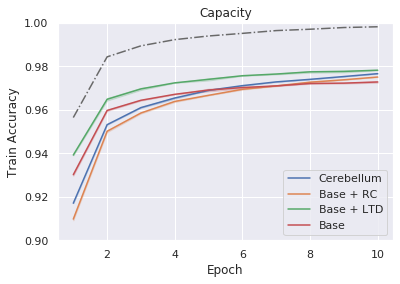

In [28]:
plt.plot(baseline_dict[ENV]['epoch'], baseline_dict[ENV]['train_acc'], '-.', color='dimgrey')
ax = sns.lineplot(x='epoch', y='train_acc', hue='', ci=95, n_boot=1000,
                  hue_order=['Cerebellum', 'Base + RC', 'Base + LTD', 'Base'],
                  data=df)
ax.set(title='Capacity', xlabel='Epoch', ylabel='Train Accuracy')
plt.ylim(0.9, 1.0)
plt.legend(loc='lower right')
plt.savefig('/home/liuyuezhangadam/Desktop/cerebellum/fig/cereb_'+ENV+'.png', dpi=300, bbox_inches='tight')

In [31]:
ATTACK = 'pgd'

EPS = 0.3
ENV = ATTACK + '-mnist'
MODEL = {'plain_none_50': 'CNN', 
         'rc-4_ma_200000': 'Cerebellum',
         'rc-4_none_200000': 'Base + RC',
         'fc_ma_5970': 'Base + LTD',
         'fc_none_5970': 'Base'}

# EPS = 2 / 255
# ENV = ATTACK + '-cifar10'
# MODEL = {'rc-4_ma_200000': 'Cerebellum',
#          'rc-4_none_200000': 'Base + RC',
#          'fc_ma_1166': 'Base + LTD',
#          'fc_none_1166': 'Base'}

df = pd.DataFrame()
table = pd.DataFrame()
for run in runs:    
    m = re.match('(.*)_(.*_.*_.*)_(.*)', run.name)
    env = m.group(1)
    model = m.group(2)
    seed = int(m.group(3))
    
    if env == ENV and model in MODEL.keys():
        temp = pd.DataFrame()
        history = run.history(samples=1000)
        temp['attack_acc'] = history['attack_acc'].dropna()
        temp['eps'] = history['eps'].dropna()
        temp[''] = MODEL[model]
        temp['seed'] = seed
        df = df.append(temp)
        
        max_attack_acc = temp[temp['eps'] == EPS]['attack_acc'].item() * 100
        name = env + '_' + model
        table = table.append(pd.DataFrame(
            {'max_attack_acc': max_attack_acc, 'name': name}, index=[run.name]))
    
calc_c95(table, 'max_attack_acc')

max_attack_acc
                              mean  count       std  ci95_hi  ci95_lo
name                                                                 
pgd-mnist_fc_ma_5970        24.585      2  2.524371   3.4986  -3.4986
pgd-mnist_fc_none_5970       1.715      2  0.572756   0.7938  -0.7938
pgd-mnist_plain_none_50      0.000      1       NaN      NaN      NaN
pgd-mnist_rc-4_ma_200000    47.970      2  3.634529   5.0372  -5.0372
pgd-mnist_rc-4_none_200000   3.305      2  2.920351   4.0474  -4.0474




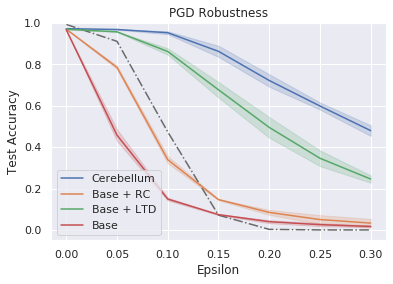

In [32]:
plt.plot(baseline_dict[ENV]['eps'], baseline_dict[ENV]['attack_acc'], '-.', color='dimgrey')
ax = sns.lineplot(x='eps', y='attack_acc', hue='', ci=95, n_boot=1000,
                  hue_order=['Cerebellum', 'Base + RC', 'Base + LTD', 'Base'],
                  data=df)
ax.set(title=ATTACK.upper() + ' Robustness', xlabel='Epsilon', ylabel='Test Accuracy')
plt.ylim(-0.05, 1.0)
plt.legend(loc='lower left')
plt.savefig('/home/liuyuezhangadam/Desktop/cerebellum/fig/cereb_'+ENV+'.png', dpi=300, bbox_inches='tight')